In [1]:
# Importing Dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.svm import SVC
import sqlite3

In [2]:
# Importing data
conn = sqlite3.connect('data.db')
churn_data = pd.read_sql_query("SELECT * FROM data", conn)
conn.close()
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [3]:
# Dropping non-essential columns in reference to churn potential
churn_data = churn_data.drop(["RowNumber", "CustomerId", "Surname", "Geography"], axis=1)
churn_data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,516,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,709,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,772,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [4]:
# Finding the number of unique values in each column
churn_data.nunique()

CreditScore            460
Gender                   2
Age                     70
Tenure                  11
Balance               6382
NumOfProducts            4
HasCrCard                2
IsActiveMember           2
EstimatedSalary       9999
Exited                   2
Complain                 2
Satisfaction Score       5
Card Type                4
Point Earned           785
dtype: int64

In [5]:
# Looking at the value counts for "Tenure" for binning
tenure_vcounts = churn_data["Tenure"].value_counts()
tenure_vcounts

Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64

In [6]:
# Looking at value counts for "Satisfaction Score" for binning
satisfaction = churn_data["Satisfaction Score"].value_counts()
satisfaction

Satisfaction Score
3    2042
2    2014
4    2008
5    2004
1    1932
Name: count, dtype: int64

In [7]:
# Looking at value counts for "Credit Score" for binning
cred_score = churn_data["CreditScore"].value_counts()
cred_score

CreditScore
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: count, Length: 460, dtype: int64

In [8]:
# Designating bins to group credit scores
bins = [299, 579, 669, 739, 799, 850]
churn_data["CreditScore"] = pd.cut(churn_data["CreditScore"], bins=bins, labels=["300-579", "580-669", "670-739", "740-799", "800-850"])

# Checking if binning was successful
churn_data["CreditScore"].value_counts()

CreditScore
580-669    3331
670-739    2428
300-579    2362
740-799    1224
800-850     655
Name: count, dtype: int64

In [9]:
bins = [0, 25000, 50000, 75000, 100000, 125000, 900000]
churn_data["EstimatedSalary"] = pd.cut(churn_data["EstimatedSalary"], bins=bins, labels=["0-25k", "25k-50k", "50k-75k", "75k-100k", "100k-125k", "125k+"])
churn_data["EstimatedSalary"].value_counts()

EstimatedSalary
125k+        3734
100k-125k    1276
50k-75k      1269
75k-100k     1268
25k-50k      1236
0-25k        1217
Name: count, dtype: int64

In [10]:
bins = [0, 25000, 50000, 75000, 100000, 125000, 900000]
churn_data["Balance"] = pd.cut(churn_data["Balance"], bins=bins, labels=["0-25k", "25k-50k", "50k-75k", "75k-100k", "100k-125k", "125k+"])
churn_data["Balance"].value_counts()

Balance
125k+        2731
100k-125k    2068
75k-100k     1160
50k-75k       349
25k-50k        69
0-25k           6
Name: count, dtype: int64

In [11]:
bins = [0, 20, 40, 60, 80, 200]
churn_data["Age"] = pd.cut(churn_data["Age"], bins=bins, labels=["0-20", "20-40", "40-60", "60-80", "80+"])
churn_data["Age"].value_counts()

Age
20-40    6330
40-60    3117
60-80     452
0-20       89
80+        12
Name: count, dtype: int64

In [12]:
# Converting categorical data to numeric with "pd.get_dummies"
numerics = pd.get_dummies(churn_data)
numerics

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned,CreditScore_300-579,CreditScore_580-669,...,EstimatedSalary_0-25k,EstimatedSalary_25k-50k,EstimatedSalary_50k-75k,EstimatedSalary_75k-100k,EstimatedSalary_100k-125k,EstimatedSalary_125k+,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,2,1,1,1,1,1,2,464,False,True,...,False,False,False,False,True,False,True,False,False,False
1,1,1,0,1,0,1,3,456,False,True,...,False,False,False,False,True,False,True,False,False,False
2,8,3,1,0,1,1,3,377,True,False,...,False,False,False,False,True,False,True,False,False,False
3,1,2,0,0,0,0,5,350,False,False,...,False,False,False,True,False,False,False,True,False,False
4,2,1,1,1,0,0,5,425,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,2,1,0,0,0,1,300,False,False,...,False,False,False,True,False,False,True,False,False,False
9996,10,1,1,1,0,0,5,771,True,False,...,False,False,False,False,True,False,False,False,True,False
9997,7,1,0,1,1,1,3,564,False,False,...,False,True,False,False,False,False,False,False,False,True
9998,3,2,1,0,1,1,2,339,False,False,...,False,False,False,True,False,False,False,True,False,False


In [13]:
# Splitting preprocessed data into featured and target arrays
y = numerics["Exited"].values
x = numerics.drop("Exited", axis = 1).values
X = numerics.drop("Exited", axis=1)

# Getting the training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [14]:
# Creating StandardScaler instances
scaler = StandardScaler()

# Fitting StandardScaler
x_scaler = scaler.fit(x_train)

# Scaling data
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [15]:
# Initialize the SVM classifier
svm_model = SVC(kernel='rbf')  # Radial Basis Function (RBF) kernel is commonly used

In [16]:
# Train the model
svm_model.fit(x_train_scaled, y_train)

SVC()

In [17]:
# Make predictions on the test set
y_pred_svm = svm_model.predict(x_test_scaled)

In [18]:
# Calculate accuracy on the test set
accuracy_svm = svm_model.score(x_test_scaled, y_test)
print("Accuracy (SVM):", accuracy_svm)

Accuracy (SVM): 0.9988


C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\d

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


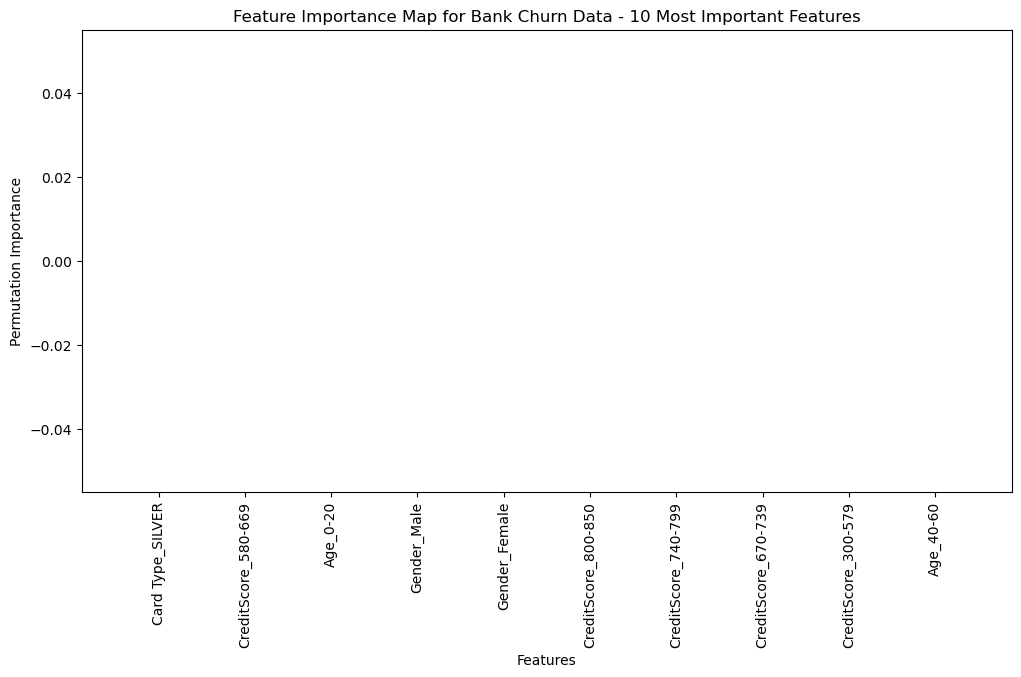